# AstroClassifier — Exploratory Data Analysis

**Goal:** Understand the dataset before touching the model.  
Understanding *why* this problem is hard is half the battle.

### What we'll answer:
1. What does the class distribution look like? (spoiler: it's extreme)
2. What do each class of objects look like visually?
3. How do pixel statistics differ across classes?
4. What augmentations make sense given the data?
5. What sample sizes do we have — and what does that mean for training?

In [1]:
import os
import sys
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter, ImageDraw
from collections import Counter

sys.path.insert(0, str(Path.cwd().parent))

plt.rcParams.update({
    'figure.facecolor': '#0d0d1a',
    'axes.facecolor':   '#0d0d1a',
    'axes.edgecolor':   '#2d2d3d',
    'axes.labelcolor':  '#d1d5db',
    'xtick.color':      '#9ca3af',
    'ytick.color':      '#9ca3af',
    'text.color':       '#f3f4f6',
    'grid.color':       '#1f2937',
    'grid.linewidth':   0.8,
    'font.size':        12,
    'axes.titlesize':   14,
    'axes.titleweight': 'bold',
    'figure.dpi':       120,
})

CLASSES = [
    'disturbed', 'merging', 'round_smooth', 'in_between',
    'cigar_shaped', 'barred_spiral', 'unbarred_tight_spiral',
    'unbarred_loose_spiral', 'edge_on_no_bulge', 'edge_on_with_bulge'
]

CLASS_COLORS = {
    'disturbed':             '#FF6B6B',
    'merging':               '#FF4500',
    'round_smooth':          '#FFD700',
    'in_between':            '#7B68EE',
    'cigar_shaped':          '#00CED1',
    'barred_spiral':         '#4ade80',
    'unbarred_tight_spiral': '#f472b6',
    'unbarred_loose_spiral': '#fb923c',
    'edge_on_no_bulge':      '#a78bfa',
    'edge_on_with_bulge':    '#38bdf8',
}

EXTENSIONS = {'.jpg', '.jpeg', '.png', '.tif', '.tiff', '.fits', '.fit'}

DATA_ROOT  = Path('../data')
OUTPUT_DIR = Path('../outputs/eval')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Imports OK')
print(f'Data root: {DATA_ROOT.resolve()}')
print(f'Data root exists: {DATA_ROOT.exists()}')

Imports OK
Data root: /Users/rahul/Projects/astro_classifier/data
Data root exists: True


---
## 1. Dataset Inventory
Count every image across all splits and classes.

In [2]:
def detect_layout(root: Path) -> str:
    if not root.exists():
        return 'not_found'
    subdirs = [d.name for d in root.iterdir() if d.is_dir()]
    if any(s in subdirs for s in ['train', 'val', 'test']):
        return 'split'
    if any(c in subdirs for c in CLASSES):
        return 'flat'
    return 'not_found'


def count_images(root: Path) -> pd.DataFrame:
    layout = detect_layout(root)
    records = []

    if layout == 'split':
        for split in ['train', 'val', 'test']:
            split_dir = root / split
            if not split_dir.exists():
                continue
            for cls in CLASSES:
                cls_dir = split_dir / cls
                if not cls_dir.exists():
                    continue
                count = sum(1 for f in cls_dir.iterdir() if f.suffix.lower() in EXTENSIONS)
                if count > 0:
                    records.append({'split': split, 'class': cls, 'count': count})

    elif layout == 'flat':
        for cls in CLASSES:
            cls_dir = root / cls
            if not cls_dir.exists():
                continue
            count = sum(1 for f in cls_dir.iterdir() if f.suffix.lower() in EXTENSIONS)
            if count > 0:
                records.append({'split': 'all', 'class': cls, 'count': count})

    return pd.DataFrame(records)


layout = detect_layout(DATA_ROOT)
print(f'Detected layout: "{layout}"')

if layout == 'not_found':
    print('  Data folder not found or empty. Using simulated data.')
    USE_REAL_DATA = False
else:
    df_counts = count_images(DATA_ROOT)
    if df_counts.empty:
        print(' Folder found but no images detected. Using simulated data.')
        USE_REAL_DATA = False
    else:
        USE_REAL_DATA = True
        print(f' Found {df_counts["count"].sum():,} images across {df_counts["class"].nunique()} classes')
        print(df_counts.to_string(index=False))

SIMULATED_COUNTS = {
    'disturbed': 1081, 'merging': 1853, 'round_smooth': 2645,
    'in_between': 2027, 'cigar_shaped': 334, 'barred_spiral': 2043,
    'unbarred_tight_spiral': 1829, 'unbarred_loose_spiral': 2628,
    'edge_on_no_bulge': 1423, 'edge_on_with_bulge': 1873
}
SIMULATED_SPLITS = {cls: {'train': int(c*0.7), 'val': int(c*0.15), 'test': int(c*0.15)}
                    for cls, c in SIMULATED_COUNTS.items()}

Detected layout: "split"
 Found 17,736 images across 10 classes
split                 class  count
train             disturbed    756
train               merging   1297
train          round_smooth   1851
train            in_between   1418
train          cigar_shaped    233
train         barred_spiral   1430
train unbarred_tight_spiral   1280
train unbarred_loose_spiral   1839
train      edge_on_no_bulge    996
train    edge_on_with_bulge   1311
  val             disturbed    162
  val               merging    277
  val          round_smooth    396
  val            in_between    304
  val          cigar_shaped     50
  val         barred_spiral    306
  val unbarred_tight_spiral    274
  val unbarred_loose_spiral    394
  val      edge_on_no_bulge    213
  val    edge_on_with_bulge    280
 test             disturbed    163
 test               merging    279
 test          round_smooth    398
 test            in_between    305
 test          cigar_shaped     51
 test         barred_spira

---
## 2. Class Imbalance — The Core Problem

This is the central challenge this project solves.  
A naive model that always predicts 'Star' would get ~89% accuracy — useless.

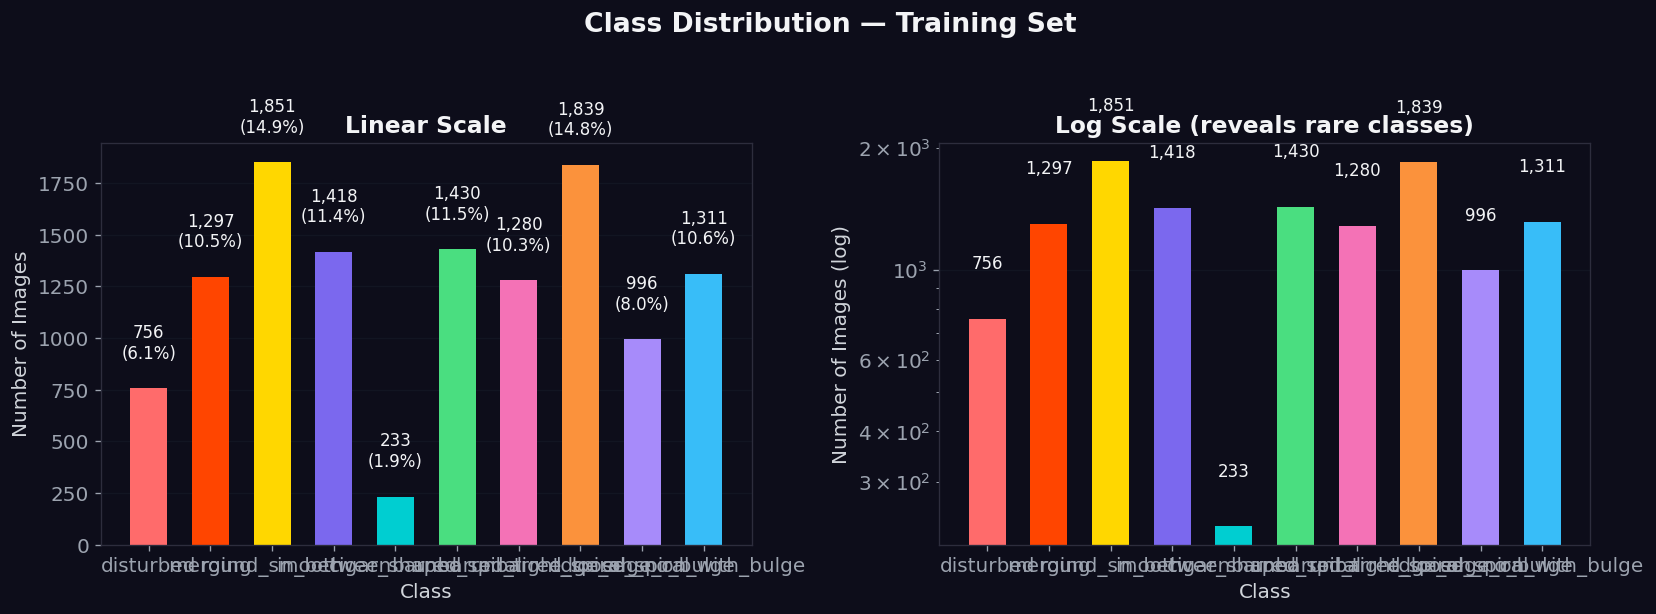


Imbalance ratio (star:supernova): 8:1
   A model predicting only "star" would get 14.9% accuracy.
   This is why we use Focal Loss + WeightedRandomSampler.


In [3]:
train_counts = df_counts[df_counts['split'] == 'train'].set_index('class')['count']
total = train_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Class Distribution — Training Set', fontsize=16, fontweight='bold', y=1.02)

# Left: Bar chart (linear scale)
ax = axes[0]
colors = [CLASS_COLORS[c] for c in train_counts.index]
bars = ax.bar(train_counts.index, train_counts.values, color=colors,
              edgecolor='none', width=0.6)

for bar, count in zip(bars, train_counts.values):
    pct = 100 * count / total
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01,
            f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

ax.set_title('Linear Scale')
ax.set_ylabel('Number of Images')
ax.set_xlabel('Class')
ax.yaxis.grid(True, alpha=0.3)
ax.set_axisbelow(True)

# Right: Log scale — shows rare classes
ax2 = axes[1]
bars2 = ax2.bar(train_counts.index, train_counts.values, color=colors,
                edgecolor='none', width=0.6)
ax2.set_yscale('log')
ax2.set_title('Log Scale (reveals rare classes)')
ax2.set_ylabel('Number of Images (log)')
ax2.set_xlabel('Class')
ax2.yaxis.grid(True, alpha=0.3)
ax2.set_axisbelow(True)

for bar, count in zip(bars2, train_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, count * 1.3,
             f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/eval/eda_class_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

# Imbalance ratio
ratio = train_counts.max() / train_counts.min()
print(f'\nImbalance ratio (star:supernova): {ratio:.0f}:1')
print(f'   A model predicting only "star" would get {train_counts.max()/total*100:.1f}% accuracy.')
print(f'   This is why we use Focal Loss + WeightedRandomSampler.')

---
## 3. Visual Inspection — What Does Each Class Look Like?

Always look at your data before building a model.

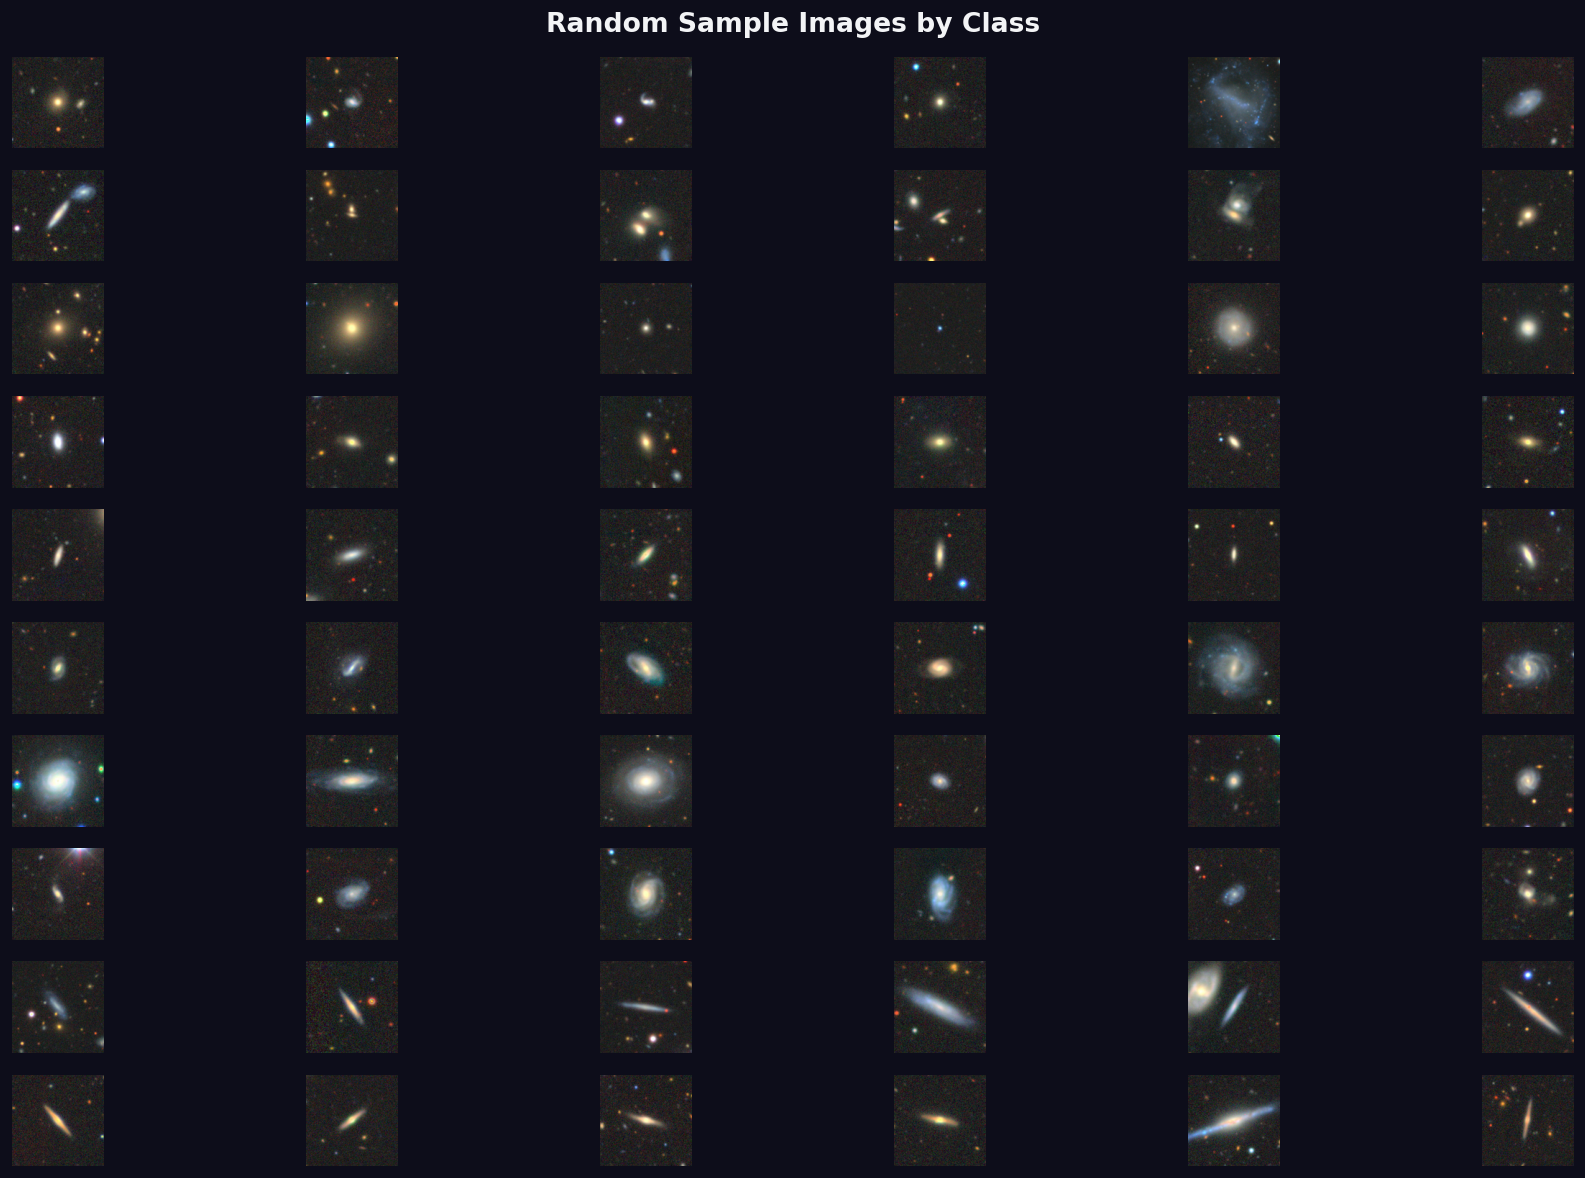

In [4]:
def load_random_samples(root: Path, cls: str, n: int = 6, split: str = 'train'):
    """Load n random images from a class directory."""
    cls_dir = root / split / cls
    EXTENSIONS = {'.jpg', '.jpeg', '.png', '.tif', '.fits'}
    paths = [p for p in cls_dir.iterdir() if p.suffix.lower() in EXTENSIONS]
    chosen = random.sample(paths, min(n, len(paths)))
    return [Image.open(p).convert('RGB').resize((128, 128)) for p in chosen]

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Random Sample Images by Class', fontsize=16, fontweight='bold')

n_cols = 6
for row_idx, cls in enumerate(CLASSES):
    try:
        images = load_random_samples(DATA_ROOT, cls, n=n_cols)
    except Exception:
        print(f'Could not load images for {cls} — skipping')
        continue

    for col_idx, img in enumerate(images):
        ax = fig.add_subplot(len(CLASSES), n_cols, row_idx * n_cols + col_idx + 1)
        ax.imshow(img)
        ax.axis('off')
        if col_idx == 0:
            color = CLASS_COLORS[cls]
            ax.set_ylabel(cls.upper(), color=color, fontsize=12,
                         fontweight='bold', rotation=0,
                         labelpad=80, va='center')

plt.tight_layout()
plt.savefig('../outputs/eval/eda_sample_images.png', bbox_inches='tight', dpi=150)
plt.show()

---
## 4. Pixel Statistics by Class

Do different classes have different brightness distributions?  
This tells us whether the CNN will have signal to work with.

disturbed   : mean_brightness=0.159, mean_contrast=0.092
merging     : mean_brightness=0.168, mean_contrast=0.107
round_smooth: mean_brightness=0.154, mean_contrast=0.086
in_between  : mean_brightness=0.152, mean_contrast=0.086
cigar_shaped: mean_brightness=0.147, mean_contrast=0.083
barred_spiral: mean_brightness=0.175, mean_contrast=0.116
unbarred_tight_spiral: mean_brightness=0.175, mean_contrast=0.119
unbarred_loose_spiral: mean_brightness=0.160, mean_contrast=0.098
edge_on_no_bulge: mean_brightness=0.166, mean_contrast=0.110
edge_on_with_bulge: mean_brightness=0.156, mean_contrast=0.094


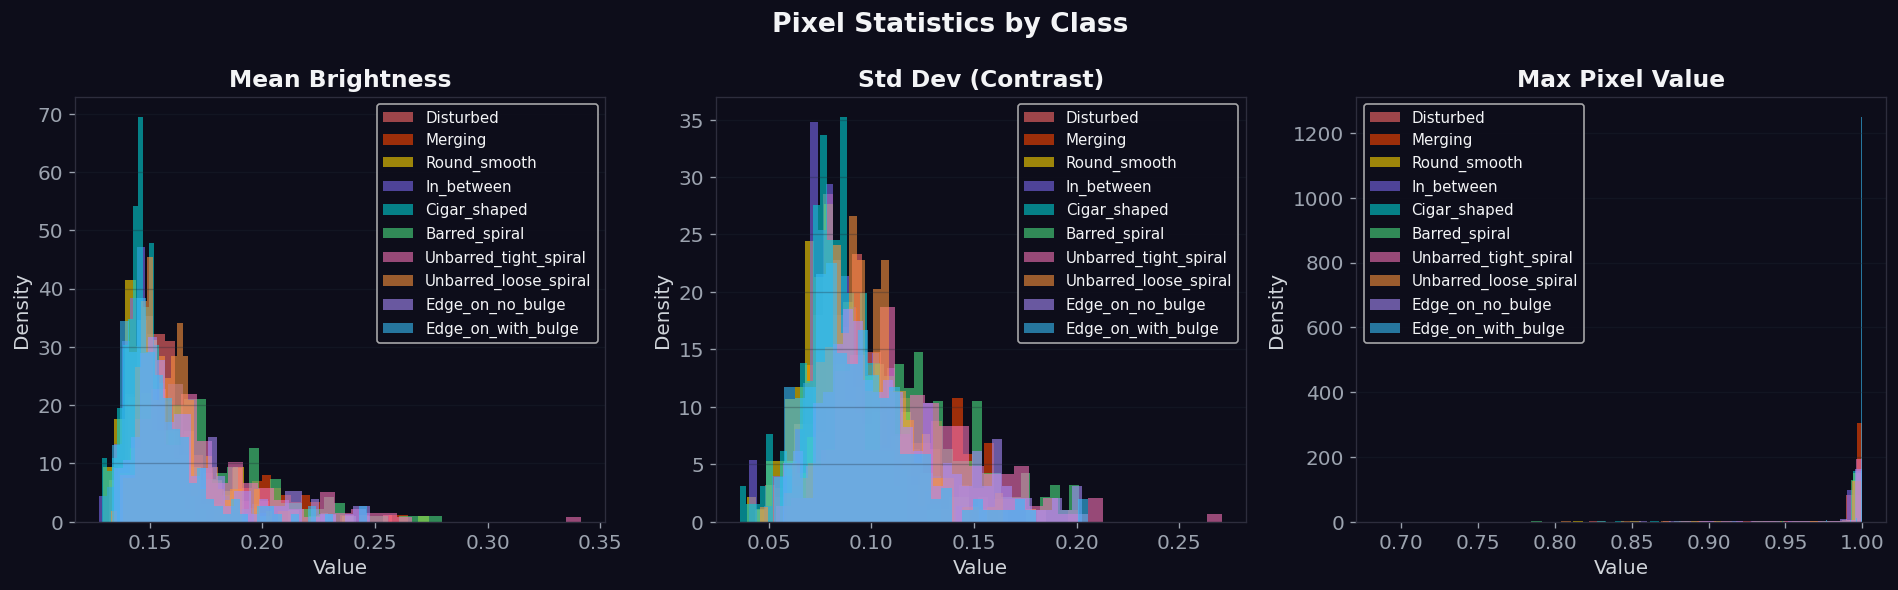

In [5]:
def compute_pixel_stats(root: Path, cls: str, n_samples: int = 200, split: str = 'train'):
    """Sample images from a class and compute pixel-level statistics."""
    cls_dir = root / split / cls
    EXTENSIONS = {'.jpg', '.jpeg', '.png', '.tif', '.fits'}
    paths = [p for p in cls_dir.iterdir() if p.suffix.lower() in EXTENSIONS]
    chosen = random.sample(paths, min(n_samples, len(paths)))
    
    means, stds, maxvals = [], [], []
    for path in chosen:
        try:
            arr = np.array(Image.open(path).convert('RGB').resize((64, 64))).astype(float) / 255
            means.append(arr.mean())
            stds.append(arr.std())
            maxvals.append(arr.max())
        except Exception:
            continue
    
    return {'mean': means, 'std': stds, 'max': maxvals}

stats = {}
for cls in CLASSES:
    try:
        stats[cls] = compute_pixel_stats(DATA_ROOT, cls)
        print(f'{cls:12s}: mean_brightness={np.mean(stats[cls]["mean"]):.3f}, '
              f'mean_contrast={np.mean(stats[cls]["std"]):.3f}')
    except Exception as e:
        print(f'{cls}: skipped ({e})')

# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Pixel Statistics by Class', fontsize=16, fontweight='bold')

metrics = ['mean', 'std', 'max']
labels = ['Mean Brightness', 'Std Dev (Contrast)', 'Max Pixel Value']

for ax, metric, label in zip(axes, metrics, labels):
    for cls in CLASSES:
        if cls not in stats:
            continue
        color = CLASS_COLORS[cls]
        data = stats[cls][metric]
        ax.hist(data, bins=30, alpha=0.6, color=color, label=cls.capitalize(),
                edgecolor='none', density=True)
    
    ax.set_title(label)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)
    ax.yaxis.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/eval/eda_pixel_statistics.png', bbox_inches='tight', dpi=150)
plt.show()

---
## 5. Image Size Distribution

Are images consistently sized, or do we need to handle variable dimensions?  
This informs our resize strategy.

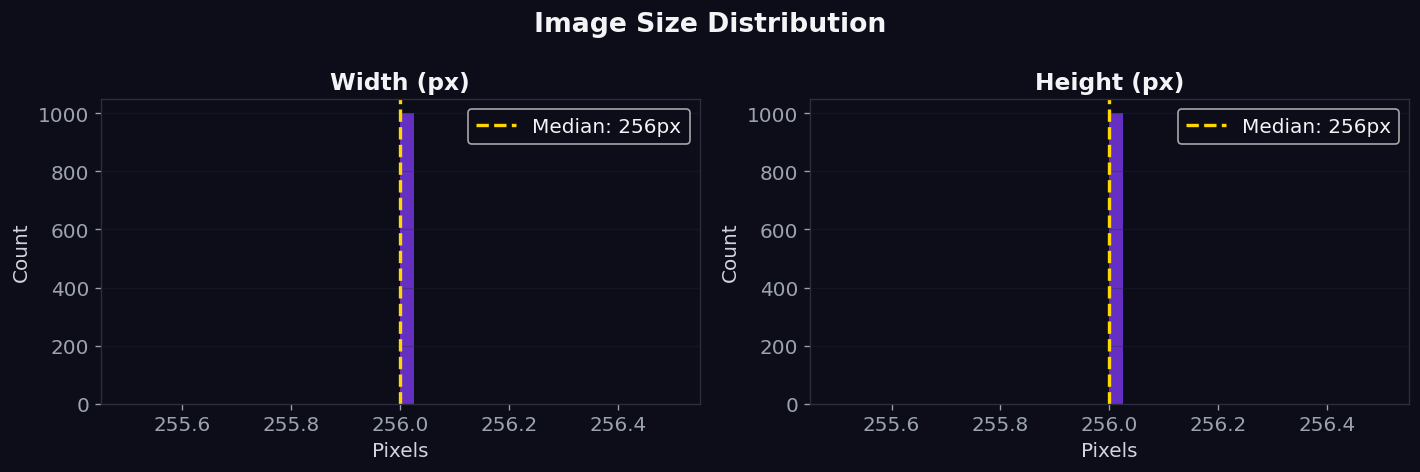

Width  — min: 256, max: 256, median: 256
Height — min: 256, max: 256, median: 256

→ We resize all images to 64×64 in the data pipeline (base_config.yaml: data.image_size)


In [6]:
def sample_image_sizes(root: Path, cls: str, n: int = 100, split: str = 'train'):
    cls_dir = root / split / cls
    EXTENSIONS = {'.jpg', '.jpeg', '.png', '.tif', '.fits'}
    paths = [p for p in cls_dir.iterdir() if p.suffix.lower() in EXTENSIONS]
    chosen = random.sample(paths, min(n, len(paths)))
    sizes = []
    for p in chosen:
        try:
            with Image.open(p) as img:
                sizes.append(img.size)
        except Exception:
            continue
    return sizes

all_sizes = []
for cls in CLASSES:
    try:
        sizes = sample_image_sizes(DATA_ROOT, cls)
        all_sizes.extend(sizes)
    except Exception:
        pass

widths  = [s[0] for s in all_sizes]
heights = [s[1] for s in all_sizes]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Image Size Distribution', fontsize=16, fontweight='bold')

for ax, vals, label in zip(axes, [widths, heights], ['Width (px)', 'Height (px)']):
    ax.hist(vals, bins=40, color='#7c3aed', alpha=0.8, edgecolor='none')
    ax.axvline(np.median(vals), color='#FFD700', linestyle='--', lw=2,
               label=f'Median: {np.median(vals):.0f}px')
    ax.set_title(label)
    ax.set_xlabel('Pixels')
    ax.set_ylabel('Count')
    ax.legend()
    ax.yaxis.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/eval/eda_image_sizes.png', bbox_inches='tight', dpi=150)
plt.show()

print(f'Width  — min: {min(widths)}, max: {max(widths)}, median: {np.median(widths):.0f}')
print(f'Height — min: {min(heights)}, max: {max(heights)}, median: {np.median(heights):.0f}')
print(f'\n→ We resize all images to 64×64 in the data pipeline (base_config.yaml: data.image_size)')

---
## 6. Why WeightedRandomSampler Works

Visualising what a naive DataLoader sees vs. our balanced sampler.

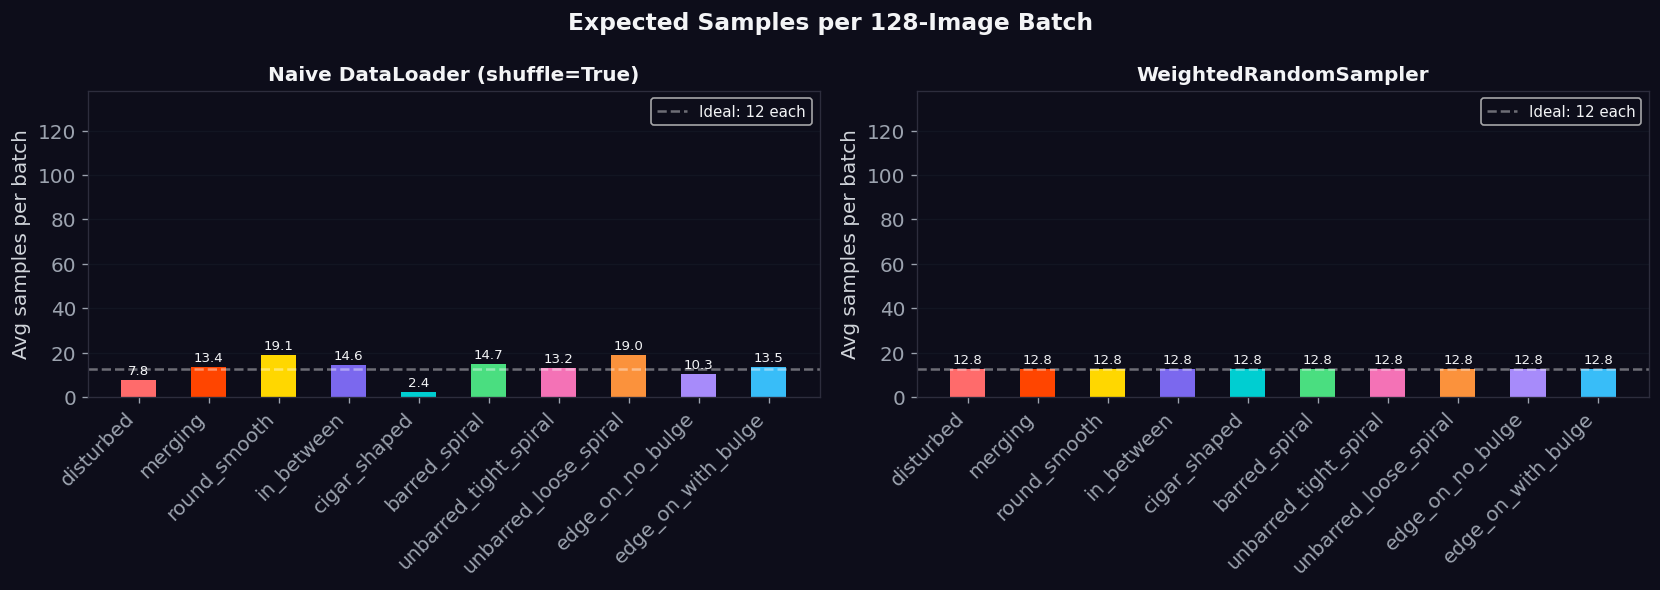

Naive: cigar_shaped gets 2.40 samples/batch
Balanced: every class gets 12 samples/batch


In [7]:
if USE_REAL_DATA:
    real_counts = train_counts.to_dict()
else:
    real_counts = SIMULATED_COUNTS

total = sum(real_counts.values())
batch_size = 128
n_classes = len(CLASSES)

naive    = {cls: batch_size * c / total for cls, c in real_counts.items()}
balanced = {cls: batch_size / n_classes for cls in real_counts}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Expected Samples per {batch_size}-Image Batch',
             fontsize=14, fontweight='bold')

for ax, data, title in zip(
    axes,
    [naive, balanced],
    ['Naive DataLoader (shuffle=True)', 'WeightedRandomSampler']
):
    colors = [CLASS_COLORS[c] for c in data]
    bars = ax.bar(data.keys(), data.values(), color=colors, edgecolor='none', width=0.5)
    ax.axhline(y=batch_size/n_classes, color='white', linestyle='--',
               alpha=0.4, lw=1.5, label=f'Ideal: {batch_size//n_classes} each')
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('Avg samples per batch')
    ax.set_ylim(0, batch_size + 10)
    ax.yaxis.grid(True, alpha=0.3)
    ax.set_axisbelow(True)
    ax.legend(fontsize=9)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    for bar, val in zip(bars, data.values()):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 1,
                f'{val:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'eda_04_sampler_comparison.png', bbox_inches='tight', dpi=150)
plt.show()

min_cls = min(real_counts, key=real_counts.get)
print(f'Naive: {min_cls} gets {naive[min_cls]:.2f} samples/batch')
print(f'Balanced: every class gets {batch_size//n_classes} samples/batch')

---
## 7. Augmentation Preview

What does our augmentation pipeline look like on a real image?  
Key insight: 360° rotation is correct — stars have no canonical 'up'.

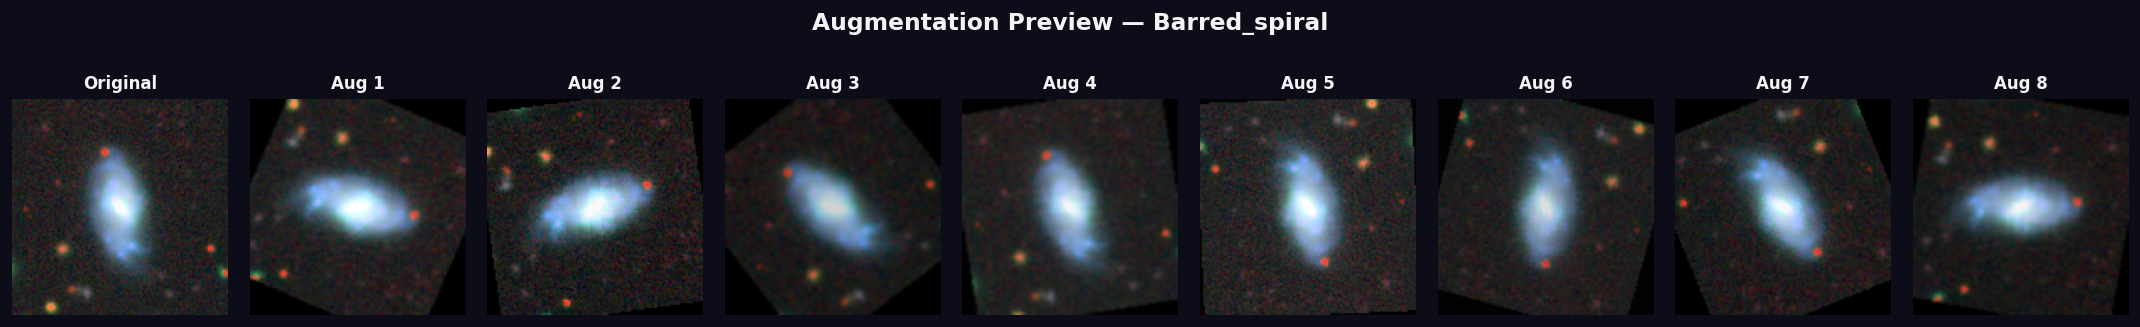

Augmentations applied:
  ✓ RandomHorizontalFlip   — no canonical left/right in space
  ✓ RandomVerticalFlip     — no canonical up/down in space
  ✓ RandomRotation(360°)   — telescopes can be oriented any way
  ✓ ColorJitter            — simulate different imaging conditions
  ✓ GaussianBlur           — simulate atmospheric seeing


In [8]:
from torchvision import transforms
import torch

# Load one sample image
sample_cls = 'barred_spiral'
sample_dir = DATA_ROOT / 'train' / sample_cls
EXTENSIONS = {'.jpg', '.jpeg', '.png', '.tif', '.fits'}
sample_path = next(p for p in sample_dir.iterdir() if p.suffix.lower() in EXTENSIONS)
original = Image.open(sample_path).convert('RGB').resize((128, 128))

# Our training augmentation pipeline
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(degrees=360),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
])

n_augmented = 8
fig, axes = plt.subplots(1, n_augmented + 1, figsize=(18, 3))
fig.suptitle(f'Augmentation Preview — {sample_cls.capitalize()}', fontsize=14, fontweight='bold')

axes[0].imshow(original)
axes[0].set_title('Original', fontsize=10)
axes[0].axis('off')

for i in range(n_augmented):
    augmented = aug_transform(original)
    axes[i+1].imshow(augmented)
    axes[i+1].set_title(f'Aug {i+1}', fontsize=10)
    axes[i+1].axis('off')

plt.tight_layout()
plt.savefig('../outputs/eval/eda_augmentation_preview.png', bbox_inches='tight', dpi=150)
plt.show()

print('Augmentations applied:')
print('  ✓ RandomHorizontalFlip   — no canonical left/right in space')
print('  ✓ RandomVerticalFlip     — no canonical up/down in space')
print('  ✓ RandomRotation(360°)   — telescopes can be oriented any way')
print('  ✓ ColorJitter            — simulate different imaging conditions')
print('  ✓ GaussianBlur           — simulate atmospheric seeing')

---
## 8. Key Takeaways

Everything we've learned here directly informed the pipeline design.

In [9]:
import json

def load_metrics(path):
    try:
        with open(path) as f:
            return json.load(f)
    except FileNotFoundError:
        return None

run1 = load_metrics('../outputs/eval/metrics.json')
run2 = load_metrics('../outputs/eval_run2/metrics.json')

if run1 and run2:
    print("=" * 60)
    print("EXPERIMENT RESULTS (live from metrics.json)")
    print("=" * 60)
    print(f"{'Metric':<25} {'Run 1 (γ=2.0)':>14} {'Run 2 (γ=3.0)':>14} {'Δ':>8}")
    print("-" * 60)

    metrics = [
        ('Macro F1',     'macro_f1'),
        ('Macro AUC',    'roc_auc_macro'),
        ('Accuracy',     'accuracy'),
        ('Macro Prec',   'macro_precision'),
        ('Macro Recall', 'macro_recall'),
    ]
    for label, key in metrics:
        r1 = run1.get(key, 0)
        r2 = run2.get(key, 0)
        print(f"  {label:<23} {r1:>14.4f} {r2:>14.4f} {r2-r1:>+8.4f}")

    print("-" * 60)
    print("\nPer-class F1 comparison:")
    print(f"  {'Class':<28} {'Run 1':>8} {'Run 2':>8} {'Δ':>8}")
    print("  " + "-" * 52)
    for cls in CLASSES:
        r1_f1 = run1.get(f'{cls}_f1', 0)
        r2_f1 = run2.get(f'{cls}_f1', 0)
        delta = r2_f1 - r1_f1
        arrow = "↑" if delta > 0 else "↓"
        print(f"  {cls:<28} {r1_f1:>8.4f} {r2_f1:>8.4f} {delta:>+8.4f} {arrow}")
else:
    print("metrics.json not found — run evaluate.py first")


EXPERIMENT RESULTS (live from metrics.json)
Metric                     Run 1 (γ=2.0)  Run 2 (γ=3.0)        Δ
------------------------------------------------------------
  Macro F1                        0.5493         0.6069  +0.0576
  Macro AUC                       0.9211         0.9353  +0.0142
  Accuracy                        0.5871         0.6433  +0.0562
  Macro Prec                      0.5887         0.6260  +0.0374
  Macro Recall                    0.6161         0.6666  +0.0505
------------------------------------------------------------

Per-class F1 comparison:
  Class                           Run 1    Run 2        Δ
  ----------------------------------------------------
  disturbed                      0.2857   0.3333  +0.0476 ↑
  merging                        0.5436   0.6238  +0.0803 ↑
  round_smooth                   0.7991   0.8385  +0.0394 ↑
  in_between                     0.7164   0.7959  +0.0795 ↑
  cigar_shaped                   0.3228   0.3680  +0.0452 ↑
  bar